# Local Retrieval Augmented Generation (RAG) from Scratch (step by step tutorial)
- [video link ](https://www.youtube.com/watch?v=qN_2fnOPY-M&t=513s)
- [source code](https://github.com/mrdbourke/simple-local-rag)

## Requirements and setup
- Check if you have GPU
- Environment setupt
- Data source (e.g. PDF)
- Internet connection

## Import PDF Document
download pdf file if we cannot import from local

In [80]:
import os
import urllib.request

# directory of data
data_dir = 'data'
page_to_start = 13

# Get PDF document path
pdf_path = 'data/Jamie Ward - The Student’s Guide to Cognitive Neuroscience-Routledge (2020).pdf'

if not os.path.exists(pdf_path):
    print("[INFO] File doesn't exist, downloading...")
    
    # Enter the URL of the PDF
    url = "https://download.library.lol/main/3042000/8fa1d36b0def1145a47a1542b8c29e7e/Jamie%20Ward%20-%20The%20Student%E2%80%99s%20Guide%20to%20Cognitive%20Neuroscience-Routledge%20%282020%29.pdf"


    urllib.request.urlretrieve(url, pdf_path)
    print('[INFO]File is downloaded')
else:
    print(f'File {pdf_path} exists.')



File data/Jamie Ward - The Student’s Guide to Cognitive Neuroscience-Routledge (2020).pdf exists.


## Processing PDF File
Use [PyMuPDF](https://github.com/pymupdf/pymupdf) to open PDFs.

In [3]:
import fitz # requires !pip install PyMuPDF, see: https://github.com/pymupdf/PyMuPDF
from tqdm.auto import tqdm # pip install tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # replace \n to blank and  remove leading and trailing spaces

    # Potentially more text formatting functions can go here
    return cleaned_text

# This only focues on text, rather than images/figuers etc.
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text() #get plain text encoded as UTF-8
        text = text_formatter(text = text) 
        pages_and_texts.append({
            "page_number": page_number - page_to_start,
            "page_char_count": len(text),
            "page_word_count": len(text.split(" ")),
            "page_setence_count_raw": len(text.split(". ")),
            "page_token_count": len(text)/4, # 1 token ~= 4 characters
            "text": text,
        })

    return pages_and_texts


pages_and_texts = open_and_read_pdf(pdf_path = pdf_path)
pages_and_texts[:2]

c:\Users\CSSA\anaconda3\envs\genai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
539it [00:01, 472.31it/s]


[{'page_number': -13,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_setence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''},
 {'page_number': -12,
  'page_char_count': 2472,
  'page_word_count': 387,
  'page_setence_count_raw': 11,
  'page_token_count': 618.0,
  'text': 'The Student’s Guide to   Cognitive Neuroscience Reflecting recent changes in the way cognition and the brain are studied, this  thoroughly updated fourth edition of this bestselling textbook provides a  comprehensive and student-friendly guide to cognitive neuroscience. Jamie  Ward provides an easy-to-follow introduction to neural structure and function,  as well as all the key methods and procedures of cognitive neuroscience, with  a view to helping students understand how they can be used to shed light on  the neural basis of cognition. The book presents a comprehensive overview of the latest theories and  findings in all the key topics in cognitive neuroscience, including vision,  hearing, attentio

## Preview sample

In [5]:
import random

random.sample(pages_and_texts, k=1)

[{'page_number': 69,
  'page_char_count': 2234,
  'page_word_count': 373,
  'page_setence_count_raw': 15,
  'page_token_count': 558.5,
  'text': '70\u2003 THE STUDENT’S GUIDE TO COGNITIVE NEUROSCIENCE either had or had not been diagnosed as schizophrenic). Although both groups  showed a number of similar frontal and temporal lobe activities, there was a  strong correlation between activity in these regions in controls and a striking  absence of correlation in the schizophrenics. Friston and Frith (1995) argued  that schizophrenia is best characterized in terms of a failure of communication  between distant brain regions (i.e., a functional disconnection). One commonly used procedure for measuring functional integration  does not use any task at all. These are known as resting state paradigms.  Participants are merely asked to lie back and rest. In the absence of a  task, the fluctuations in brain activity are little more than noise. However,  in brain regions that are functionally conn

## Preview RAG data

In [6]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_setence_count_raw,page_token_count,text
0,-13,0,1,1,0.00,
1,-12,2472,387,11,618.00,The Student’s Guide to Cognitive Neuroscienc...
2,-11,647,99,2,161.75,The Student’s Guide to Cognitive Neuroscienc...
3,-10,75,13,1,18.75,THE STUDENT’S GUIDE TO COGNITIVE ­NEUROSCIE...
4,-9,1461,238,5,365.25,Fourth edition published 2020 by Routledge 2 P...


## Statistics

In [7]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_setence_count_raw,page_token_count
count,539.00,539.00,539.00,539.00,539.00
mean,256.00,3082.05,514.65,35.69,770.51
std,155.74,1115.53,181.24,47.41,278.88
min,-13.00,0.00,1.00,1.00,0.00
25%,121.50,2382.50,406.00,16.00,595.62
50%,256.00,3121.00,525.00,21.00,780.25
75%,390.50,3709.50,624.00,25.00,927.38
max,525.00,5251.00,871.00,194.00,1312.75


## Token count
why would we care about token count?

Token count is important to think about because:
1. Embedding models don't deal with infinte tokens.
2. LLMs don't deal with infinte tokens.

For example an embedding model may gave been trained to embed sequences of 384 tokens into numerical space(sentence-transformers `all-mpnet-base-v2`, see: [pretrained_model](https//ww.sbert.net/docs/pretrained_models.html))

As for LLMs, they can't accept infinete tokens in their context window

## Further text processing (splitting pages into sentences)
Two ways to do this:
1. We've done this by splitting on ". ".
2. We can do this with a NLP library such as [spaCy](https://spacy.io/usage) and [nltk](https://www.nltk.org/).


In [8]:
from spacy.lang.en import English

nlp = English()

# Add a sentencizer pipeline, see https://spacy.io./api/sentencizer
nlp.add_pipe("sentencizer")

# Create document instance
doc = nlp("Cognitive Neuroscience Reflecting recent changes in the way.")
assert len(list(doc.sents)) == 1

# Print out our sentences split
list(doc.sents)

[Cognitive Neuroscience Reflecting recent changes in the way.]

In [9]:
for item in tqdm(pages_and_texts):
    item["sentences"] = list(nlp(item["text"]).sents)

    # Make sure all sentences are strings (the default type is a spaCy datatype)
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # Count the senteces
    item["page_sentence_count_spacy"] = len(item["sentences"])


100%|██████████| 539/539 [00:02<00:00, 224.46it/s]


### Select random sample

In [10]:
random.sample(pages_and_texts, k=1)

[{'page_number': 487,
  'page_char_count': 5046,
  'page_word_count': 803,
  'page_setence_count_raw': 159,
  'page_token_count': 1261.5,
  'text': '488\u2003 References Meaney, M. J. (2001). Maternal care, gene expression,  and the transmission of individual differences in  stress reactivity across generations. Annual Review of  Neuroscience, 24, 1161–1192. doi: 10.1146/annurev. neuro.24.1.1161. Mechelli, A., Gorno-Tempini, M. L., & Price, C.  J. (2003). Neuroimaging studies of word and  pseudoword reading: Consistencies, inconsistencies,  and limitations. Journal of Cognitive Neuroscience,  15, 260–271. Mechelli, A., Josephs, O., Ralph, M. A. L., McClelland, J. L.,   & Price, C. J. (2007). Dissociating stimulus-driven  semantic and phonological effect during reading and  naming. Human Brain Mapping, 28(3), 205–217. Medina, J., & Fischer-Baum, S. (2017). Single-case  cognitive neuropsychology in the age of big data.  Cognitive Neuropsychology, 34(7–8), 440–448. doi:  10.1080/02643294.

In [11]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_setence_count_raw,page_token_count,page_sentence_count_spacy
count,539.00,539.00,539.00,539.00,539.00,539.00
mean,256.00,3082.05,514.65,35.69,770.51,29.35
std,155.74,1115.53,181.24,47.41,278.88,23.33
min,-13.00,0.00,1.00,1.00,0.00,0.00
25%,121.50,2382.50,406.00,16.00,595.62,18.00
50%,256.00,3121.00,525.00,21.00,780.25,23.00
75%,390.50,3709.50,624.00,25.00,927.38,29.00
max,525.00,5251.00,871.00,194.00,1312.75,102.00


### Chunking our sentences together
The concept of splitting larger pieces of text into smaller ones is often reffered to as text splitting or chunking.

There is 100 % coorrect way to do this.

We''ll keep it simple and split into groups of 10 sentences (however, you could alsl try 5, 7, 8, whatever you like).

There are frameworkds such as LangChain which can help with this, however, we'll stick with Python for now.
https://python.langchain.com/docs/modules/data_connection/document_transformers.


Why we do this:
1. So our texts are easier to filter (smaller groups of text can be easier to inspect that large passages of text).
2. So our text chunk can fit into our embedding model context window (e.g. 384 tokens as a limit).
3. So our contexts passed to an LLM can be more specific and focused

In [20]:
# Define split size to turn groups of sentences into chunks
num_sentence_chunk_size = 10

# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

# Loop through pages and texts and split sentences into chunks
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = split_list(input_list=item["sentences"], slice_size=num_sentence_chunk_size)
    item["num_chunks"] = len(item["sentence_chunks"])





100%|██████████| 539/539 [00:00<00:00, 180209.63it/s]


In [21]:
# Sample an example from the group (note: many samples have only 1 chunk as they have <=10 sentences total)
random.sample(pages_and_texts, k=1)

[{'page_number': 349,
  'page_char_count': 3446,
  'page_word_count': 547,
  'page_setence_count_raw': 20,
  'page_token_count': 861.5,
  'text': '350\u2003 THE STUDENT’S GUIDE TO COGNITIVE NEUROSCIENCE (e.g., Chinese)? The evidence suggests that the same reading system is  indeed used across other languages (Rueckl, et al., 2015), but the different  routes and components may be weighted differently according to the  culture-specific demands. Functional imaging suggests that reading uses similar brain regions across  different languages, albeit to varying degrees. Italian speakers activate more  strongly areas involved in phonemic processing when reading words, whereas  English speakers activate more strongly regions implicated in lexical retrieval  (Paulesu et al., 2000). Studies of Chinese speakers also support a common  network for reading Chinese logographs and reading Roman-alphabetic  transcriptions of Chinese (the latter being a system, called pinyin, used to  help in teaching C

In [40]:
# Create a DataFrame to get stats
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_setence_count_raw,page_token_count,page_sentence_count_spacy,num_chunks
count,539.00,539.00,539.00,539.00,539.00,539.00,539.00
mean,256.00,3082.05,514.65,35.69,770.51,29.35,3.38
std,155.74,1115.53,181.24,47.41,278.88,23.33,2.35
min,-13.00,0.00,1.00,1.00,0.00,0.00,0.00
25%,121.50,2382.50,406.00,16.00,595.62,18.00,2.00
50%,256.00,3121.00,525.00,21.00,780.25,23.00,3.00
75%,390.50,3709.50,624.00,25.00,927.38,29.00,3.00
max,525.00,5251.00,871.00,194.00,1312.75,102.00,11.00


### Splitting each chunk into its own item
1. Embed each chunk of sentences into its own numerical representation
2. Create new list of dictionaries containing a single chunk of sentences with relative information sucha as page number as well statistics about each chunk.

In [33]:
import re

# Split each chunk into its own item
pages_and_chunks = []
for item in tqdm(pages_and_texts):
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]
        
        # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
        # split sentence using ". " 
        joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # Get stats about the chunk
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
        pages_and_chunks.append(chunk_dict)

# How many chunks do we have?
len(pages_and_chunks)

100%|██████████| 539/539 [00:00<00:00, 12276.97it/s]


1821

In [44]:
# View a random sample
random.sample(pages_and_chunks, k=1)

[{'page_number': 113,
  'sentence_chunk': 'Are these assumptions plausible? • •Critically evaluate the role of group studies in neuropsychological research. • •What are the advantages and disadvantages of using single cases to draw inferences about normal cognitive functioning? • •How have TMS and tDCS studies contributed to our knowledge of brain plasticity? • •Compare and contrast lesion methods arising from organic brain damage with TMS and tES. ONLINE RESOURCES Visit the companion website at www.routledge.com/cw/ward for: • • References to key papers and readings • • Video lectures and interviews on key topics with leading psychologist Elizabeth Warrington and author Jamie Ward, as well as demonstrations of and lectures on brain stimulation • • Multiple-choice questions and interactive flashcards to test your knowledge • • Downloadable glossary',
  'chunk_char_count': 817,
  'chunk_word_count': 122,
  'chunk_token_count': 204.25}]

In [46]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1821.00,1821.00,1821.00,1821.00
mean,310.96,897.43,138.21,224.36
std,161.79,498.37,76.85,124.59
min,-12.00,5.00,1.00,1.25
25%,169.00,523.00,77.00,130.75
50%,338.00,829.00,130.00,207.25
75%,466.00,1270.00,200.00,317.50
max,524.00,4439.00,587.00,1109.75


### Filter chunks of text for short chunks
remove item with short sentence in chunk, these chunks may not contain much useful information

In [47]:
# Show random chunks with under 30 tokens in length
min_token_length = 30
for row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'Chunk token ocunt: {row[1]["chunk_token_count"]} | Text: {row[1]["sentence_chunk"]}')

Chunk token ocunt: 23.25 | Text: For example, the superior temporal sulcus lies between the superior and medial temporal gyri.
Chunk token ocunt: 28.0 | Text: From Barraclough et al. (2005). © 2005 by the Massachusetts Institute of Technology. Reproduced with permission.
Chunk token ocunt: 12.0 | Text: Dysgraphia Difficulties in spelling and writing.
Chunk token ocunt: 11.25 | Text: A comprehensive selection of advanced topics.
Chunk token ocunt: 18.25 | Text: THE STUDENT’S GUIDE  TO COGNITIVE ­NEUROSCIENCE JAMIE WARD Fourth Edition


Lookds like many of these are headers and footers of different pages.

They don't seem to offer too much information.

Let's filter our DataFrame/list of dictionaries to only include chunks with over 30 tokens in length.

In [48]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -12,
  'sentence_chunk': 'The Student’s Guide to  Cognitive Neuroscience Reflecting recent changes in the way cognition and the brain are studied, this thoroughly updated fourth edition of this bestselling textbook provides a comprehensive and student-friendly guide to cognitive neuroscience. Jamie Ward provides an easy-to-follow introduction to neural structure and function, as well as all the key methods and procedures of cognitive neuroscience, with a view to helping students understand how they can be used to shed light on the neural basis of cognition. The book presents a comprehensive overview of the latest theories and findings in all the key topics in cognitive neuroscience, including vision, hearing, attention, memory, speech and language, numeracy, executive function, social and emotional behavior and developmental neuroscience. Throughout, case studies, newspaper reports, everyday examples and student- friendly pedagogy are used to help students understand t

### Embedding our text chunks
- text -> numbers
- similar meaning texts have dimilar numerical representation

In [50]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device="cpu")

# Create a list of sentences to turn into numbers
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

# Sentences are encoded/embedded by calling model.encode()
embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

# See the embeddings
for sentence, embedding in embeddings_dict.items():
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07982454e-02  3.03164609e-02 -2.01217923e-02  6.86484575e-02
 -2.55255867e-02 -8.47687386e-03 -2.07212070e-04 -6.32377639e-02
  2.81606745e-02 -3.33353467e-02  3.02634109e-02  5.30721210e-02
 -5.03527038e-02  2.62288693e-02  3.33313644e-02 -4.51577567e-02
  3.63044813e-02 -1.37120159e-03 -1.20171094e-02  1.14947222e-02
  5.04510775e-02  4.70857173e-02  2.11913772e-02  5.14606424e-02
 -2.03746744e-02 -3.58889550e-02 -6.67760614e-04 -2.94393618e-02
  4.95859087e-02 -1.05639603e-02 -1.52014010e-02 -1.31759921e-03
  4.48197499e-02  1.56023111e-02  8.60379430e-07 -1.21391343e-03
 -2.37978753e-02 -9.09375725e-04  7.34487409e-03 -2.53929920e-03
  5.23370244e-02 -4.68043610e-02  1.66214723e-02  4.71579656e-02
 -4.15599272e-02  9.01959487e-04  3.60278003e-02  3.42214368e-02
  9.68227237e-02  5.94829023e-02 -1.64984372e-02 -3.51248942e-02
  5.92515618e-03 -7.07919884e-04 -2.4103

only one sentence?

In [51]:
single_sentence = "Yo! How cool are embeddings?"
single_embedding = embedding_model.encode(single_sentence)
print(f"Sentence: {single_sentence}")
print(f"Embedding:\n{single_embedding}")
print(f"Embedding size: {single_embedding.shape}")

Sentence: Yo! How cool are embeddings?
Embedding:
[-1.97447911e-02 -4.51076683e-03 -4.98486962e-03  6.55445009e-02
 -9.87673271e-03  2.72836164e-02  3.66426110e-02 -3.30218975e-03
  8.50077160e-03  8.24952219e-03 -2.28497945e-02  4.02430333e-02
 -5.75200319e-02  6.33691922e-02  4.43207175e-02 -4.49506640e-02
  1.25284679e-02 -2.52011549e-02 -3.55292894e-02  1.29559087e-02
  8.67024250e-03 -1.92917567e-02  3.55636678e-03  1.89505555e-02
 -1.47128431e-02 -9.39848460e-03  7.64176296e-03  9.62185021e-03
 -5.98922372e-03 -3.90168950e-02 -5.47824986e-02 -5.67458058e-03
  1.11644529e-02  4.08067293e-02  1.76319099e-06  9.15305968e-03
 -8.77257623e-03  2.39382815e-02 -2.32784431e-02  8.04999620e-02
  3.19177173e-02  5.12600737e-03 -1.47708422e-02 -1.62525252e-02
 -6.03213012e-02 -4.35689613e-02  4.51211631e-02 -1.79053508e-02
  2.63366681e-02 -3.47866938e-02 -8.89171846e-03 -5.47675565e-02
 -1.24372784e-02 -2.38606595e-02  8.33496973e-02  5.71241640e-02
  1.13328444e-02 -1.49594927e-02  9.2037

### Put model to cuda and create embeddings

In [52]:
%%time

# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090

# Create embeddings one by one on the GPU
for item in tqdm(pages_and_chunks_over_min_token_len):
    item["embedding"] = embedding_model.encode(item["sentence_chunk"])

100%|██████████| 1755/1755 [00:53<00:00, 32.93it/s]

CPU times: total: 6min 14s
Wall time: 56.2 s


### Create input data for model

In [54]:
# Turn text chunks into a single list
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [55]:
%%time

# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

text_chunk_embeddings

CPU times: total: 1min 54s
Wall time: 43.8 s


tensor([[-0.0330, -0.0027, -0.0481,  ...,  0.0049, -0.0325, -0.0283],
        [ 0.0292, -0.0014, -0.0219,  ..., -0.0036, -0.0363, -0.0366],
        [-0.0140, -0.0356, -0.0247,  ...,  0.0015, -0.0348, -0.0103],
        ...,
        [ 0.0291,  0.0177, -0.0484,  ...,  0.0160, -0.0418, -0.0038],
        [ 0.0055, -0.0100, -0.0086,  ...,  0.0019, -0.0146, -0.0293],
        [ 0.0110,  0.0366, -0.0357,  ..., -0.0216, -0.0040, -0.0173]],
       device='cuda:0')

### Save embeddings to file
Since creating embeddings is timely process

In [56]:
# Save embeddings to file
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = os.path.join(data_dir, 'text_chunks_and_embeddings_df.csv')
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

Import chunked data

In [57]:
# Import saved file and view
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-12,The Student’s Guide to Cognitive Neuroscience...,2279,333,569.75,[-3.30289602e-02 -2.72259233e-03 -4.80539463e-...
1,-12,He is the author of a number of books on socia...,165,27,41.25,[ 2.92444322e-02 -1.35945121e-03 -2.18915269e-...
2,-11,The Student’s Guide to Cognitive Neuroscience...,640,92,160.00,[-1.40064461e-02 -3.55704427e-02 -2.46967077e-...
3,-9,Fourth edition published 2020 by Routledge 2 P...,1452,229,363.00,[ 2.12833118e-02 4.14945185e-03 -2.91914176e-...
4,-8,Contents About the author ix Preface to the f...,1061,152,265.25,[-4.13218932e-03 5.48444688e-02 -5.59893698e-...


### Sive of our embeddings

In [59]:
import random

import torch
import numpy as np 
import pandas as pd

device = "cuda" if torch.cuda.is_available() else "cpu"

# Import texts and embedding df
text_chunks_and_embedding_df = pd.read_csv(embeddings_df_save_path)

# Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

# Convert texts and embedding df to list of dicts
pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

# Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1755, 768])

In [60]:
text_chunks_and_embedding_df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-12,The Student’s Guide to Cognitive Neuroscience...,2279,333,569.75,"[-0.0330289602, -0.00272259233, -0.0480539463,..."
1,-12,He is the author of a number of books on socia...,165,27,41.25,"[0.0292444322, -0.00135945121, -0.0218915269, ..."
2,-11,The Student’s Guide to Cognitive Neuroscience...,640,92,160.00,"[-0.0140064461, -0.0355704427, -0.0246967077, ..."
3,-9,Fourth edition published 2020 by Routledge 2 P...,1452,229,363.00,"[0.0212833118, 0.00414945185, -0.0291914176, -..."
4,-8,Contents About the author ix Preface to the f...,1061,152,265.25,"[-0.00413218932, 0.0548444688, -0.0559893698, ..."


In [75]:
embeddings[0]

torch.Size([768])

### Semantic Search

In [62]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", 
                                      device=device) # choose the device to load the model to

In [63]:
# 1. Define the query
# Note: This could be anything. But since we're working with a nutrition textbook, we'll stick with nutrition-based queries.
query = "structure and function of the neuron"
print(f"Query: {query}")

# 2. Embed the query to the same numerical space as the text examples 
# Note: It's important to embed your query with the same model you embedded your examples with.
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity scores with the dot product (we'll time this for fun)
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0] # cosine similarity
end_time = timer()

print(f"Time take to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

# 4. Get the top-k results (we'll keep this to 5)
top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: structure and function of the neuron
Time take to get scores on 1755 embeddings: 0.00177 seconds.


torch.return_types.topk(
values=tensor([0.7331, 0.6977, 0.6475, 0.6435, 0.6023], device='cuda:0'),
indices=tensor([51, 52, 85, 84, 63], device='cuda:0'))

In [73]:
temp = util.dot_score(a=query_embedding, b=embeddings)
print(temp.shape)
print(temp)

torch.Size([1, 1755])
tensor([[0.4247, 0.3103, 0.4236,  ..., 0.3424, 0.2610, 0.2592]],
       device='cuda:0')


### Larger embeddings
simulate normal distribution of 100 larger shape of embeddings -> larger embeddings makes faster dot_score?

In [64]:
larger_embeddings = torch.randn(100*embeddings.shape[0], 768).to(device)
print(f"Embeddings shape: {larger_embeddings.shape}")

# Perform dot product across 168,000 embeddings
start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=larger_embeddings)[0]
end_time = timer()

print(f"Time take to get scores on {len(larger_embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

Embeddings shape: torch.Size([175500, 768])
Time take to get scores on 175500 embeddings: 0.00038 seconds.


In [76]:
# Define helper function to print wrapped text 
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

### Decode top 5 embedding to string

In [85]:
print(f"Query: '{query}'\n")
print("Results:")
# Loop through zipped together scores and indicies from torch.topk
for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
    # Print the page number too so we can reference the textbook further (and check the results)
    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'structure and function of the neuron'

Results:
Score: 0.7331
Text:
It is hard to begin a chapter about the brain without waxing lyrical. The brain
is the physical organ that makes all our mental life possible. It enables us to
read these words, and to consider thoughts that we have never considered
before—or even to create thoughts that no human has considered before. This book
will scratch the surface of how this is all possible, but the purpose of this
chapter is more mundane. It offers a basic guide to the structure of the brain,
starting from a description of neurons and working up to a description of how
these are organized into different neuroanatomical systems. The emphasis is on
the human brain rather than the brain of other species. STRUCTURE AND FUNCTION
OF THE NEURON All neurons have basically the same structure. They consist of
three components: a cell body (or soma), dendrites and an axon, as shown in
Figure 2.1. Although neurons have the same basic structure and 

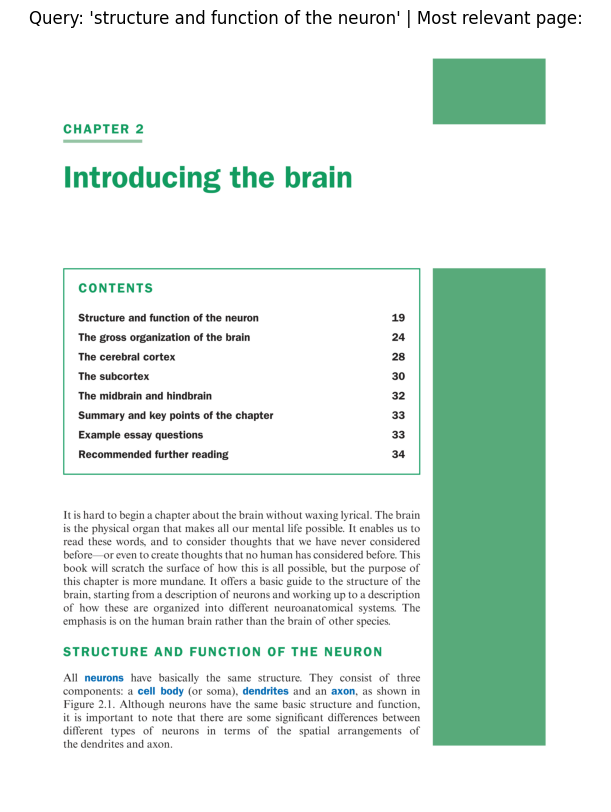

In [87]:
import fitz

# Open PDF and load target page
# pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(18 + page_to_start) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=1000)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

### Define function
1. dot_product
2. cosine similarity

In [88]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

### Functionizing our semantic search pipeline

In [89]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_time = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [90]:
query = "what is dendrites"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices

[INFO] Time taken to get scores on 1755 embeddings: 0.00006 seconds.


(tensor([0.4453, 0.3790, 0.3648, 0.3492, 0.3337], device='cuda:0'),
 tensor([52, 55, 56, 76, 51], device='cuda:0'))

In [91]:
# Print out the texts of the top scores
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

[INFO] Time taken to get scores on 1755 embeddings: 0.00006 seconds.
Query: what is dendrites

Results:
Score: 0.4453
20  THE STUDENT’S GUIDE TO COGNITIVE NEUROSCIENCE The cell body contains the
nucleus and other organelles. The nucleus contains the genetic code, and this is
involved in protein synthesis. Proteins serve a wide variety of functions from
providing scaffolding to chemical signaling (they can act as neurotransmitters
and receptors in neurons). Neurons receive information from other neurons and
they make a “decision” about this information (by changing their own activity)
that can then be passed on to other neurons. From the cell body, a number of
branching structures called dendrites enable communication with other neurons.
Dendrites receive information from other neurons in close proximity. The number
and structure of the dendritic branches can vary significantly depending on the
type of neuron (i.e., where it is to be found in the brain). The axon, by
contrast, sends inf

### Checking local GPU memory availability

Let's find out what hardware we've got available and see what kind of model(s) we'll be able to load.

> **Note:** You can also check this with the `!nvidia-smi` command.

In [92]:
# Get GPU available memory
import torch
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")

Available GPU memory: 4 GB


In [95]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
if gpu_memory_gb < 5.1:
    print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
    
elif gpu_memory_gb < 8.1:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
    use_quantization_config = True 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb < 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
    use_quantization_config = False 
    model_id = "google/gemma-2b-it"
elif gpu_memory_gb > 19.0:
    print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
    use_quantization_config = False 
    model_id = "google/gemma-7b-it"

try:
    print(f"use_quantization_config set to: {use_quantization_config}")
    print(f"model_id set to: {model_id}")
except:
    print("You don't have enough GPU to run LLM locally")

Your available GPU memory is 4GB, you may not have enough memory to run a Gemma LLM locally without quantization.
You don't have enough GPU to run LLM locally
